In [ ]:
# First Train DL
# Next Streamlit app
# Deploy locally
# Deploy online

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle competitions download -c dog-breed-identification

 99% 685M/691M [00:03<00:00, 236MB/s]
100% 691M/691M [00:03<00:00, 226MB/s]


In [ ]:
!unzip "/content/dog-breed-identification.zip"
!rm "/content/dog-breed-identification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline 
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
#Data Paths
train_dir = '/content/train/'
test_dir = '/content/test/'

In [ ]:
#Read train labels.
labels_dataframe = pd.read_csv("/content/labels.csv")
labels_dataframe.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels_dataframe.shape

(10222, 2)

In [ ]:
print(f"number of pics in test_dir {len(os.listdir(test_dir))}")
print(f"number of pics in train dir {len(os.listdir(train_dir))}")

number of pics in test_dir 10357
number of pics in train dir 10222


In [ ]:
dog_breeds = sorted(list(set(labels_dataframe.breed)))
n_classes = len(dog_breeds)
print(n_classes)
print(dog_breeds[:10])

120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle']


In [ ]:
#Map each label string to an integer label.
class_to_num = dict(zip(dog_breeds, range(n_classes)))
class_to_num

In [ ]:
labels_dataframe.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
(train_dir+labels_dataframe.id+'.jpg')[0]

'/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [ ]:
cv2.imread((train_dir+labels_dataframe.id+'.jpg')[0]).shape

(375, 500, 3)

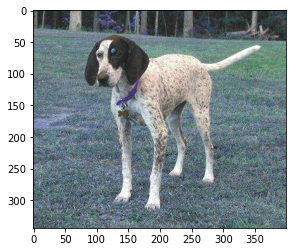

In [ ]:
plt.imshow(cv2.imread((train_dir+labels_dataframe.id+'.jpg')[3]))

In [ ]:
labels_dataframe['file_name'] = labels_dataframe['id'].apply(lambda x:train_dir+f"{x}.jpg")

In [ ]:
labels_dataframe.head()

,id,breed,file_name
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/train/000bec180eb18c7604dcecc8fe0dba0...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/train/001513dfcb2ffafc82cccf4d8bbaba9...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/train/001cdf01b096e06d78e9e5112d41939...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/train/00214f311d5d2247d5dfe4fe24b2303...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/train/0021f9ceb3235effd7fcde7f7538ed6...


In [ ]:
labels_dataframe['breed'] = labels_dataframe.breed.map(class_to_num)

In [ ]:
labels_dataframe.head()

,id,breed,file_name
0,000bec180eb18c7604dcecc8fe0dba07,19,/content/train/000bec180eb18c7604dcecc8fe0dba0...
1,001513dfcb2ffafc82cccf4d8bbaba97,37,/content/train/001513dfcb2ffafc82cccf4d8bbaba9...
2,001cdf01b096e06d78e9e5112d419397,85,/content/train/001cdf01b096e06d78e9e5112d41939...
3,00214f311d5d2247d5dfe4fe24b2303d,15,/content/train/00214f311d5d2247d5dfe4fe24b2303...
4,0021f9ceb3235effd7fcde7f7538ed62,49,/content/train/0021f9ceb3235effd7fcde7f7538ed6...


In [ ]:
y = to_categorical(labels_dataframe.breed)

In [ ]:
y.shape

(10222, 120)

#### Lets Design model architecture for feature extraction


In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 , preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess
from tensorflow.keras.layers import concatenate

input_shape = (331,331,3)
input_layer = Input(shape=input_shape)


#first extractor inception_resnet
preprocessor_resnet = Lambda(resnet_preprocess)(input_layer)
inception_resnet = ResNet50V2(weights = 'imagenet',
                                     include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_resnet)

preprocessor_densenet = Lambda(densenet_preprocess)(input_layer)
densenet = DenseNet121(weights = 'imagenet',
                                     include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_densenet)


merge = concatenate([inception_resnet,densenet])
model = Model(inputs = input_layer, outputs = merge)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 331, 331, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 331, 331, 3)  0           ['input_1[0][0]']                
                                                                                                  
 resnet50v2 (Functional)        (None, 2048)         23564800    ['lambda[0][0]']             

In [ ]:
model.save('feature_extractor.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('./feature_extractor.h5')

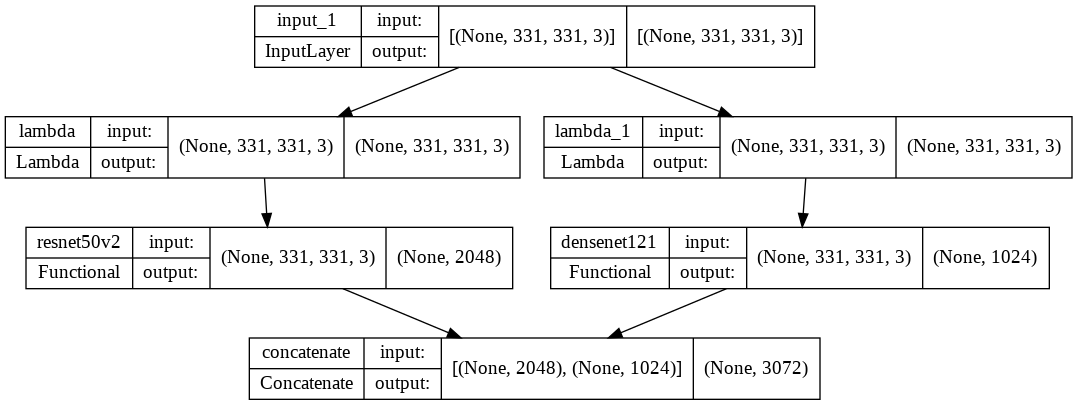

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

In [ ]:
model.output.shape

TensorShape([None, 3072])

In [ ]:
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 20
    X = np.zeros([data_size,3072], dtype=np.uint8)
    datagen = ImageDataGenerator() 
    generator = datagen.flow_from_dataframe(df,
    x_col = 'file_name', class_mode = None, 
    batch_size=20, shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    i = 0
    
    for input_batch in tqdm(generator):
        input_batch = model.predict(input_batch)
        X[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
            break
    return X

In [ ]:
X = feature_extractor(labels_dataframe)

Found 10222 validated image filenames.


100%|█████████▉| 511/512 [08:03<00:00,  1.06it/s]


In [ ]:
X.shape

(10222, 3072)

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 5],
       ...,
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 2]], dtype=uint8)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
EarlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/checkpoint',monitor = 'val_loss',mode = 'min',save_best_only= True)
my_callback=[EarlyStop_callback,checkpoint]

In [ ]:
deepnn = tf.keras.models.Sequential([
    InputLayer(X.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])

deepnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = deepnn.fit(X , y,
            batch_size=128,
            epochs=70,
            validation_split=0.1 ,
           callbacks = my_callback)

Epoch 1/70
72/72 [==============================] - 2s 17ms/step - loss: 3.2938 - accuracy: 0.2748 - val_loss: 1.4980 - val_accuracy: 0.7742
Epoch 2/70
72/72 [==============================] - 1s 12ms/step - loss: 1.3372 - accuracy: 0.6844 - val_loss: 0.8653 - val_accuracy: 0.8260
Epoch 3/70
72/72 [==============================] - 1s 12ms/step - loss: 0.8896 - accuracy: 0.7936 - val_loss: 0.6871 - val_accuracy: 0.8377
Epoch 4/70
72/72 [==============================] - 1s 12ms/step - loss: 0.6951 - accuracy: 0.8330 - val_loss: 0.5983 - val_accuracy: 0.8534
Epoch 5/70
72/72 [==============================] - 1s 12ms/step - loss: 0.5779 - accuracy: 0.8591 - val_loss: 0.5505 - val_accuracy: 0.8553
Epoch 6/70
72/72 [==============================] - 1s 12ms/step - loss: 0.4944 - accuracy: 0.8781 - val_loss: 0.5245 - val_accuracy: 0.8416
Epoch 7/70
72/72 [==============================] - 1s 17ms/step - loss: 0.4498 - accuracy: 0.8878 - val_loss: 0.5057 - val_accuracy: 0.8524
Epoch 8/70
72

#### Plot the result

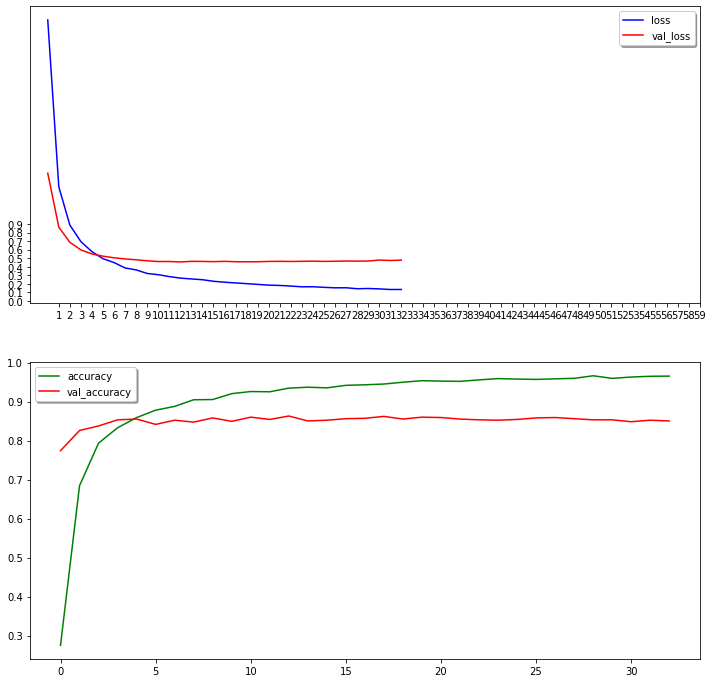

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
plt.show()

In [ ]:
from keras.models import load_model
deepnn.save('/content/dogbreed.h5')

In [ ]:
import pickle
with open('dog_breeds_category.pickle', 'wb') as handle:
    pickle.dump(dog_breeds, handle, protocol=pickle.HIGHEST_PROTOCOL)